In [ ]:
import numpy as np

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# 1) kD Tree

class KDTree:
    def __init__(self, matrix):
        self.matrix = matrix
        self.left = None
        self.right = None
        self.split_axis = 0
        self.median_point = None
        if matrix.shape[0] > 0:
            self.build_tree(matrix, depth=0)

    def build_tree(self, points, depth):
        if len(points) == 0:
            return

        axis = depth % points.shape[1]
        sorted_points = points[points[:, axis].argsort()]
        median_index = len(points) // 2

        self.median_point = sorted_points[median_index]
        self.split_axis = axis

        left_points = sorted_points[:median_index]
        right_points = sorted_points[median_index + 1:]

        if len(left_points) > 0:
            self.left = KDTree(left_points)
        if len(right_points) > 0:
            self.right = KDTree(right_points)

    def find_nearest(self, vector):
        return self._search(vector, self, float('inf'), None)[1]

    def _search(self, vector, tree, best_dist, best_point):
        if tree is None:
            return best_dist, best_point

        dist = np.linalg.norm(vector - tree.median_point)

        if dist < best_dist:
            best_dist = dist
            best_point = tree.median_point

        axis = tree.split_axis
        if vector[axis] < tree.median_point[axis]:
            best_dist, best_point = self._search(vector, tree.left, best_dist, best_point)
            if (vector[axis] + best_dist) >= tree.median_point[axis]:
                best_dist, best_point = self._search(vector, tree.right, best_dist, best_point)
        else:
            best_dist, best_point = self._search(vector, tree.right, best_dist, best_point)
            if (vector[axis] - best_dist) <= tree.median_point[axis]:
                best_dist, best_point = self._search(vector, tree.left, best_dist, best_point)

        return best_dist, best_point

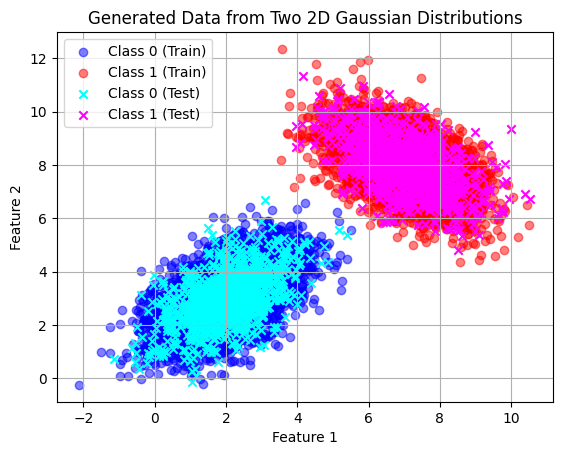

In [ ]:
# 2) Construct 2 datasets from multivariate Gaussian distribution

mean1 = [2, 3]
cov1 = [[1, 0.5], [0.5, 1]]

mean2 = [7, 8]
cov2 = [[1, -0.5], [-0.5, 1]]

data1 = np.random.multivariate_normal(mean1, cov1, 5000)
data2 = np.random.multivariate_normal(mean2, cov2, 5000)

X = np.vstack((data1, data2))
y = np.hstack((np.zeros(5000), np.ones(5000)))

mask = np.random.rand(10000) < 0.8
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]

# And its plot
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Class 0 (Train)', alpha=0.5)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='red', label='Class 1 (Train)', alpha=0.5)
plt.scatter(X_test[y_test == 0][:, 0], X_test[y_test == 0][:, 1], color='cyan', label='Class 0 (Test)', marker='x')
plt.scatter(X_test[y_test == 1][:, 0], X_test[y_test == 1][:, 1], color='magenta', label='Class 1 (Test)', marker='x')

plt.title("Generated Data from Two 2D Gaussian Distributions")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

Classification Accuracy: 99.90%


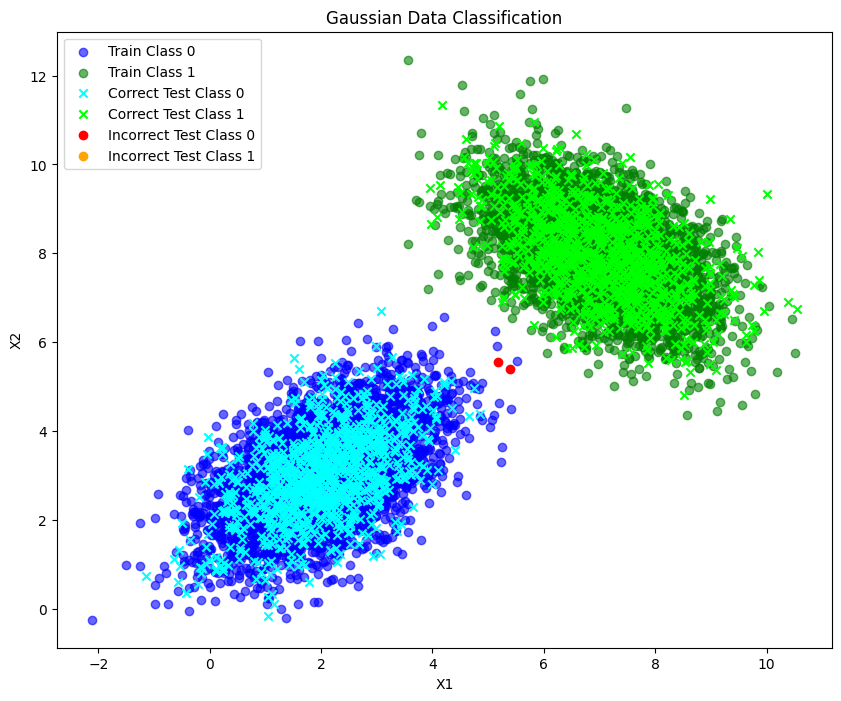

In [ ]:
# 3) Linear classifier

X_train_aug = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_aug = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

beta = np.linalg.inv(X_train_aug.T @ X_train_aug) @ X_train_aug.T @ y_train

y_pred = X_test_aug @ beta
y_pred_class = (y_pred >= 0.5).astype(int)

accuracy = np.mean(y_pred_class == y_test)
print(f'Classification Accuracy: {accuracy * 100:.2f}%')

train_class_0 = X_train[y_train == 0]
train_class_1 = X_train[y_train == 1]

correct_class_0 = X_test[(y_test == 0) & (y_pred_class == 0)]
correct_class_1 = X_test[(y_test == 1) & (y_pred_class == 1)]
incorrect_class_0 = X_test[(y_test == 0) & (y_pred_class == 1)]
incorrect_class_1 = X_test[(y_test == 1) & (y_pred_class == 0)]

plt.figure(figsize=(10, 8))
plt.scatter(train_class_0[:, 0], train_class_0[:, 1], color='blue', label='Train Class 0', alpha=0.6)
plt.scatter(train_class_1[:, 0], train_class_1[:, 1], color='green', label='Train Class 1', alpha=0.6)
plt.scatter(correct_class_0[:, 0], correct_class_0[:, 1], color='cyan', label='Correct Test Class 0', marker='x')
plt.scatter(correct_class_1[:, 0], correct_class_1[:, 1], color='lime', label='Correct Test Class 1', marker='x')
plt.scatter(incorrect_class_0[:, 0], incorrect_class_0[:, 1], color='red', label='Incorrect Test Class 0', marker='o')
plt.scatter(incorrect_class_1[:, 0], incorrect_class_1[:, 1], color='orange', label='Incorrect Test Class 1', marker='o')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Gaussian Data Classification')
plt.show()

Nearest Neighbors Classification Accuracy: 98.74%


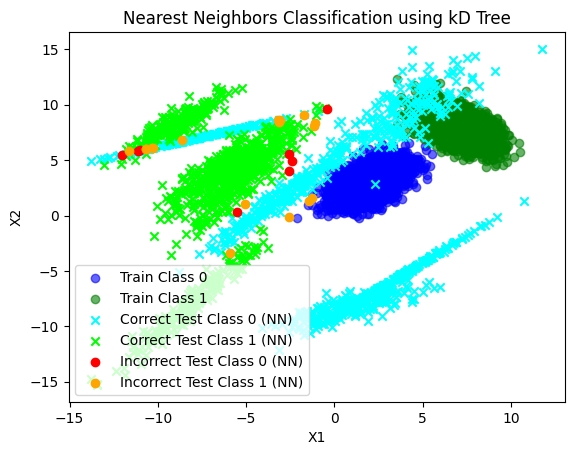

In [ ]:
# 4) Nearest neighbor classification

kdtree = KDTree(X_train)

y_test_pred_nn = np.zeros(len(X_test))

for i, test_point in enumerate(X_test):
    nearest_neighbor = kdtree.find_nearest(test_point)

    nn_index = np.where((X_train == nearest_neighbor).all(axis=1))[0][0]

    y_test_pred_nn[i] = y_train[nn_index]

accuracy_nn = np.mean(y_test_pred_nn == y_test)
print(f'Nearest Neighbors Classification Accuracy: {accuracy_nn * 100:.2f}%')

correct_class_0_nn = X_test[(y_test == 0) & (y_test_pred_nn == 0)]
correct_class_1_nn = X_test[(y_test == 1) & (y_test_pred_nn == 1)]
incorrect_class_0_nn = X_test[(y_test == 0) & (y_test_pred_nn == 1)]
incorrect_class_1_nn = X_test[(y_test == 1) & (y_test_pred_nn == 0)]


plt.scatter(train_class_0[:, 0], train_class_0[:, 1], color='blue', label='Train Class 0', alpha=0.6)
plt.scatter(train_class_1[:, 0], train_class_1[:, 1], color='green', label='Train Class 1', alpha=0.6)

plt.scatter(correct_class_0_nn[:, 0], correct_class_0_nn[:, 1], color='cyan', label='Correct Test Class 0 (NN)', marker='x')
plt.scatter(correct_class_1_nn[:, 0], correct_class_1_nn[:, 1], color='lime', label='Correct Test Class 1 (NN)', marker='x')

plt.scatter(incorrect_class_0_nn[:, 0], incorrect_class_0_nn[:, 1], color='red', label='Incorrect Test Class 0 (NN)', marker='o')
plt.scatter(incorrect_class_1_nn[:, 0], incorrect_class_1_nn[:, 1], color='orange', label='Incorrect Test Class 1 (NN)', marker='o')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Nearest Neighbors Classification using kD Tree')
plt.show()

Linear Classification Accuracy: 99.85%
Nearest Neighbors Classification Accuracy: 99.95%


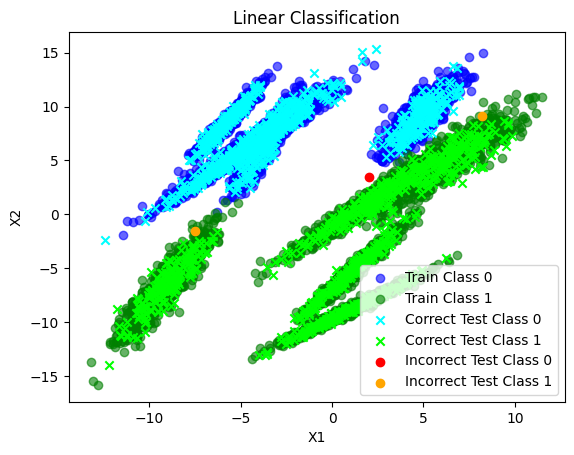

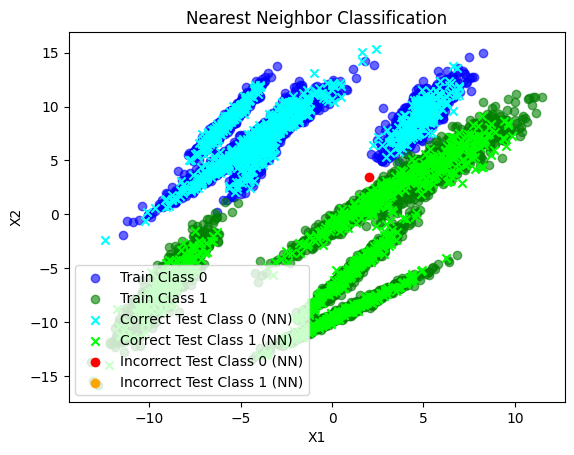

In [ ]:
# 5) Both classifications w/ multiple distributions

num_distributions = 10
samples_per_distribution = 1000
dimensions = 2


means = [np.random.uniform(-10, 10, dimensions) for _ in range(num_distributions)]
covariances = [np.random.uniform(0.5, 2.0, (dimensions, dimensions)) for _ in range(num_distributions)]
for i in range(num_distributions):
    covariances[i] = np.dot(covariances[i], covariances[i].T)

data = []
labels = []

for i in range(num_distributions):
    samples = np.random.multivariate_normal(means[i], covariances[i], samples_per_distribution)
    data.append(samples)
    labels.append(np.full(samples_per_distribution, i // 5))

X = np.vstack(data)
y = np.hstack(labels)

indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

mask = np.random.rand(X.shape[0]) < 0.8
X_train, X_test = X[mask], X[~mask]
y_train, y_test = y[mask], y[~mask]


X_train_aug = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_test_aug = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

beta = np.linalg.inv(X_train_aug.T @ X_train_aug) @ X_train_aug.T @ y_train

y_pred = X_test_aug @ beta
y_pred_class = (y_pred >= 0.5).astype(int)

accuracy_linear = np.mean(y_pred_class == y_test)
print(f'Linear Classification Accuracy: {accuracy_linear * 100:.2f}%')

kdtree = KDTree(X_train)

y_test_pred_nn = np.zeros(len(X_test), dtype=int)

for i, test_point in enumerate(X_test):
    nearest_neighbor = kdtree.find_nearest(test_point)
    nn_index = np.where((X_train == nearest_neighbor).all(axis=1))[0][0]
    y_test_pred_nn[i] = y_train[nn_index]

accuracy_nn = np.mean(y_test_pred_nn == y_test)
print(f'Nearest Neighbors Classification Accuracy: {accuracy_nn * 100:.2f}%')


# linear classification
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='green', label='Train Class 1', alpha=0.6)

plt.scatter(X_test[(y_test == 0) & (y_pred_class == 0)][:, 0], X_test[(y_test == 0) & (y_pred_class == 0)][:, 1], color='cyan', label='Correct Test Class 0', marker='x')
plt.scatter(X_test[(y_test == 1) & (y_pred_class == 1)][:, 0], X_test[(y_test == 1) & (y_pred_class == 1)][:, 1], color='lime', label='Correct Test Class 1', marker='x')
plt.scatter(X_test[(y_test == 0) & (y_pred_class == 1)][:, 0], X_test[(y_test == 0) & (y_pred_class == 1)][:, 1], color='red', label='Incorrect Test Class 0', marker='o')
plt.scatter(X_test[(y_test == 1) & (y_pred_class == 0)][:, 0], X_test[(y_test == 1) & (y_pred_class == 0)][:, 1], color='orange', label='Incorrect Test Class 1', marker='o')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Linear Classification')
plt.show()

# NN classification
plt.scatter(X_train[y_train == 0][:, 0], X_train[y_train == 0][:, 1], color='blue', label='Train Class 0', alpha=0.6)
plt.scatter(X_train[y_train == 1][:, 0], X_train[y_train == 1][:, 1], color='green', label='Train Class 1', alpha=0.6)

plt.scatter(X_test[(y_test == 0) & (y_test_pred_nn == 0)][:, 0], X_test[(y_test == 0) & (y_test_pred_nn == 0)][:, 1], color='cyan', label='Correct Test Class 0 (NN)', marker='x')
plt.scatter(X_test[(y_test == 1) & (y_test_pred_nn == 1)][:, 0], X_test[(y_test == 1) & (y_test_pred_nn == 1)][:, 1], color='lime', label='Correct Test Class 1 (NN)', marker='x')
plt.scatter(X_test[(y_test == 0) & (y_test_pred_nn == 1)][:, 0], X_test[(y_test == 0) & (y_test_pred_nn == 1)][:, 1], color='red', label='Incorrect Test Class 0 (NN)', marker='o')
plt.scatter(X_test[(y_test == 1) & (y_test_pred_nn == 0)][:, 0], X_test[(y_test == 1) & (y_test_pred_nn == 0)][:, 1], color='orange', label='Incorrect Test Class 1 (NN)', marker='o')

plt.xlabel('X1')
plt.ylabel('X2')
plt.legend()
plt.title('Nearest Neighbor Classification')
plt.show()